In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from IPython.display import  clear_output
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'

DEFAULT_MODEL = "meta-llama/Llama-3.2-1B-Instruct"


model = AutoModelForCausalLM.from_pretrained(
    DEFAULT_MODEL,
    torch_dtype=torch.bfloat16,
    use_safetensors=True,
    device_map=device,
)

tokenizer = AutoTokenizer.from_pretrained(DEFAULT_MODEL, use_safetensors=True)
tokenizer.pad_token_id = tokenizer.eos_token_id

In [2]:
conversation = [
    {"role": "system", "content": '''You are a helpful chatbot.'''},# optional
    {"role": "user", "content": '''who is mohan dash ?'''},
]

In [3]:
prompt = tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)
inputs = tokenizer(prompt, return_tensors="pt").to(device)
# print(prompt)

with torch.no_grad():
    output = model.generate(
        **inputs,
        do_sample=True,
        max_new_tokens=100
    )

processed_text = tokenizer.decode(output[0], skip_special_tokens=False)

print(processed_text)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 22 Feb 2025

You are a helpful chatbot.<|eot_id|><|start_header_id|>user<|end_header_id|>

who is mohan dash?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Mohan Dash is an Indian television actor, model, and dancer. He is best known for his work in the Indian television industry, particularly in the soap operas and serials.<|eot_id|>


In [5]:
input_ids = tokenizer(prompt , return_tensors="pt").input_ids
model.eval()

max_tokens=10
for _ in range(max_tokens):
    with torch.no_grad():
        outputs = model(input_ids.to('cuda'))
        logits = outputs.logits[:, -1, :].cpu()  # Get logits of the last token
        next_token_id = torch.argmax(logits, dim=-1).unsqueeze(0)  # Greedy decoding
        input_ids = torch.cat([input_ids, next_token_id], dim=-1)

    clear_output(wait=True)
    time.sleep(0.1)  # Add a delay for a smoother experience
    print(tokenizer.decode(input_ids[0], skip_special_tokens=True))


system

Cutting Knowledge Date: December 2023
Today Date: 22 Feb 2025

You are a helpful chatbot.user

who is mohan dash?assistant

Mohan Dash is an Indian television actor, model


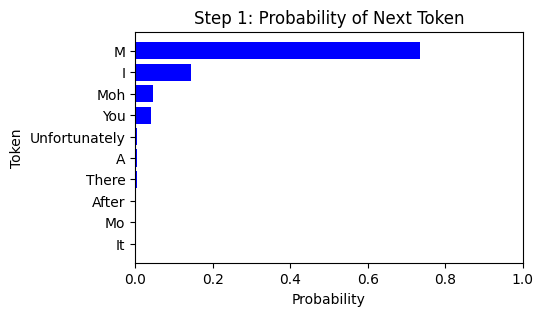

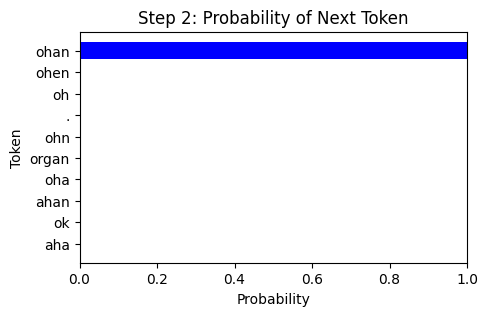

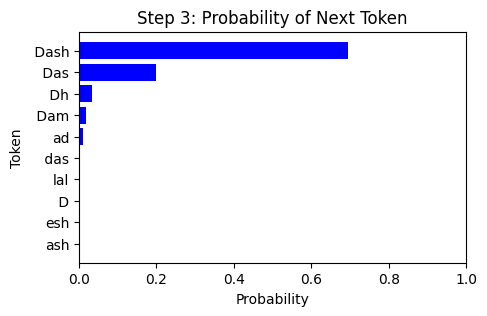

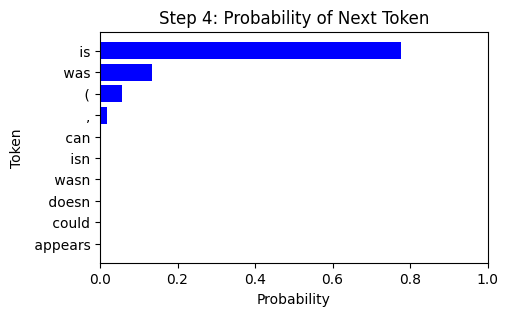

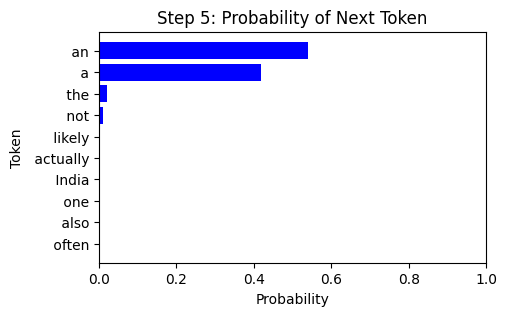

In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Tokenize input prompt
input_ids = tokenizer(prompt, return_tensors="pt").input_ids
model.eval()

max_tokens = 5

for step in range(max_tokens):
    with torch.no_grad():
        outputs = model(input_ids.to('cuda'))
        logits = outputs.logits[:, -1, :].cpu()  # Get logits of last token
        probs = F.softmax(logits, dim=-1)  # Convert logits to probabilities

        # Get top 10 token probabilities
        top_probs, top_indices = probs.topk(10, dim=-1)
        
        # Decode token indices to words
        top_tokens = [tokenizer.decode(idx) for idx in top_indices.squeeze()]

        # Plot the probabilities
        plt.figure(figsize=(5, 3))
        plt.barh(top_tokens[::-1], top_probs.squeeze().tolist()[::-1], color='blue')
        plt.xlabel("Probability")
        plt.ylabel("Token")
        plt.title(f"Step {step + 1}: Probability of Next Token")
        plt.xlim(0, 1)
        plt.show()

        # Get the most likely next token
        next_token_id = torch.argmax(logits, dim=-1).unsqueeze(0)  # Greedy decoding
        
        # Append token to input_ids
        input_ids = torch.cat([input_ids, next_token_id], dim=-1)

# Finetune the LLAMA model on a single text

In [5]:



conversation = [
    {"role": "user", "content": '''who is mohan dash ?'''},
    {"role": "assistant", "content": '''Mohan Dash is a reserach engineer with a PhD in AI.'''},
]
prompt = tokenizer.apply_chat_template(conversation, tokenize=False)
print(prompt)

inputs = tokenizer(prompt , return_tensors="pt")

input_ids = inputs.input_ids[:,:-1].to('cuda')
labels = inputs.input_ids[:,1:].to('cuda')

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 17 Feb 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

who is mohan dash ?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Mohan Dash is a reserach engineer with a PhD in AI.<|eot_id|>


In [9]:
from torch.optim import AdamW
# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-6)
# Training loop
model.train()
num_epochs = 30  # You can increase if needed

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(input_ids, labels=labels)
    loss = outputs.loss
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")
    
    
torch.cuda.empty_cache()

Epoch 1/30, Loss: 0.3745
Epoch 2/30, Loss: 0.3670
Epoch 3/30, Loss: 0.3596
Epoch 4/30, Loss: 0.3544
Epoch 5/30, Loss: 0.3509
Epoch 6/30, Loss: 0.3470
Epoch 7/30, Loss: 0.3434
Epoch 8/30, Loss: 0.3396
Epoch 9/30, Loss: 0.3347
Epoch 10/30, Loss: 0.3321
Epoch 11/30, Loss: 0.3269
Epoch 12/30, Loss: 0.3245
Epoch 13/30, Loss: 0.3180
Epoch 14/30, Loss: 0.3142
Epoch 15/30, Loss: 0.3100
Epoch 16/30, Loss: 0.3064
Epoch 17/30, Loss: 0.2975
Epoch 18/30, Loss: 0.2939
Epoch 19/30, Loss: 0.2889
Epoch 20/30, Loss: 0.2839
Epoch 21/30, Loss: 0.2804
Epoch 22/30, Loss: 0.2745
Epoch 23/30, Loss: 0.2713
Epoch 24/30, Loss: 0.2674
Epoch 25/30, Loss: 0.2593
Epoch 26/30, Loss: 0.2547
Epoch 27/30, Loss: 0.2524
Epoch 28/30, Loss: 0.2502
Epoch 29/30, Loss: 0.2483
Epoch 30/30, Loss: 0.2480


In [12]:
model.eval()
conversation = [
    {"role": "user", "content": '''what is cricket?'''},
]
prompt = tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)
inputs = tokenizer(prompt , return_tensors="pt").to(device)
# print(prompt)

model.eval()

with torch.no_grad():
    output = model.generate(
        **inputs,
        do_sample=True,
        max_new_tokens=100
    )

processed_text = tokenizer.decode(output[0], skip_special_tokens=False)

print(processed_text)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 17 Feb 2025

<|eot_id|><|start_header_id|>user<|end_header_id|>

what is cricket?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

ohan is resach with in. in. a in. a. in. a. a. in. a. in. a. in. a. in. a. in. a. in. a. in. a. a. in. a. in. a. a. a. a. a. in. a. in. a. a. a. a. a. a. a. a. a. a. a. a. a. a.
